Import package + model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cobra
from cobra.io import (
    load_json_model,
    save_json_model,
    load_matlab_model,
    save_matlab_model,
    read_sbml_model,
    write_sbml_model,
)
from cobra.flux_analysis import flux_variability_analysis
from scipy.integrate import solve_ivp
from tqdm import tqdm

In [32]:
M_xanthus = read_sbml_model("../M_xanthus_model.sbml")
M_xanthus

Name,myxo_model
Memory address,7a865a237b10
Number of metabolites,1280
Number of reactions,1367
Number of genes,1192
Number of groups,0
Objective expression,1.0*OF_BIOMASS - 1.0*OF_BIOMASS_reverse_80d2e
Compartments,"c, e"


In [33]:
E_coli = read_sbml_model("../E_coli_model.sbml")
E_coli

Name,iML1515
Memory address,7a865a424190
Number of metabolites,1877
Number of reactions,2714
Number of genes,1516
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


**COBRApy implementation**

In [ ]:
##COBRApy
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species (Can put more)
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with E_coli:
        add_dynamic_bounds(E_coli, y)

        cobra.util.add_lp_feasibility(E_coli)
        feasibility = cobra.util.fix_objective_as_constraint(E_coli)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            E_coli,
            [
                "BIOMASS_Ec_iML1515_core_75p37M",
                "EX_glc__D_e",
            ],
            ["max", "max"],
        )

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description("t = {:.3f}".format(t))

    return fluxes


dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with E_coli:

        add_dynamic_bounds(E_coli, y)

        cobra.util.add_lp_feasibility(E_coli)
        feasibility = cobra.util.fix_objective_as_constraint(E_coli)

    return feasibility - infeasible_event.epsilon


infeasible_event.epsilon = 1e-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [ ]:
ts = np.linspace(0, 10, 20)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method="BDF",
    )

0it [00:00, ?it/s]

t = 0.000: : 5it [00:06,  1.25s/it]


KeyboardInterrupt: 

In [101]:
sol

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 0.000e+00  5.263e-01  1.053e+00  1.579e+00  2.105e+00
             2.632e+00  3.158e+00  3.684e+00  4.211e+00  4.737e+00
             5.263e+00]
        y: [[ 1.000e-01  1.620e-01 ...  1.479e+00  1.483e+00]
            [ 1.000e+01  9.552e+00 ...  3.738e-02  7.906e-03]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 805
     njev: 29
      nlu: 238

**My code**

In [ ]:
E_coli.reactions.EX_ac_e  # not used in model
E_coli.reactions.EX_etoh_e  # not used in model
E_coli.reactions.EX_for_e  # not used in model

Reaction identifier,EX_k_e
Name,K+ exchange
Memory address,0x75da2d010b90
Stoichiometry,k_e <=> Potassium <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
M_xanthus.reactions.EX_Fe3_e.id = 'EX_fe3_e'
M_xanthus.reactions.EX_glc_D_e.id = 'EX_glc__D_e'

In [57]:
t = 0
tf = 50
steps = 0.5
time_point = [0]
it = 1
y = [100, 100, 100, 10]
fluxes_E = []
fluxes_M = []

reactions_list_E_coli = []
for reaction in E_coli.reactions:
    reactions_list_E_coli.append(reaction.id)

reactions_list_M_xanthus = []
for reaction in M_xanthus.reactions:
    reactions_list_M_xanthus.append(reaction.id)


def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose. \n
    :param sbml model: The model you want to add dynamic bounds. \n
    :param list(int) y: A list of the metabolite quantities in environment. In order: glucose, oxygen, amonium, glutamate.
    """
    glucose, oxygen, ammonium, fructose = y  # expand the boundary species (Can put more)

    glucose_max_import = -10 * glucose / (5 + glucose) # calculate the max import value for the metabolites
    oxygen_max_import = -10 * oxygen / (5 + oxygen)
    ammonium_max_import = -10 * ammonium / (5 + ammonium)
    fructose_max_import = -10 * fructose / (5 + fructose)

    E_coli.reactions.EX_glc__D_e.lower_bound = glucose_max_import  # change the limit of importation with the mex import
    M_xanthus.reactions.EX_glc__D_e.lower_bound = 0
    model.reactions.EX_o2_e.lower_bound = oxygen_max_import
    model.reactions.EX_nh4_e.lower_bound = ammonium_max_import
    model.reactions.EX_no_e.lower_bound = fructose_max_import
    M_xanthus.reactions.EX_glu_L_e.bounds = [0,0]


def update_metabolites(fluxes, y):
    """Updtate the metabolites quantities depending of the fluxes. \n
    :param list(int) fluxes: The list of the fluxes. \n
    :param list(int) y: A list of the metabolite quantities in environment. In order: glucose, oxygen, amonium, glutamate.
    """
    glucose, oxygen, ammonium, fructose = y  # expand the boundary species (Can put more)

    glucose = glucose + fluxes["EX_glc__D_e"]  # calculate the number of metabolites
    oxygen = oxygen + fluxes["EX_o2_e"]
    ammonium = ammonium + fluxes["EX_nh4_e"]
    fructose = fructose + fluxes["EX_no_e"]

    y = (
        glucose,
        oxygen,
        ammonium,
        fructose
    )  # changing the value of the metabolites
    return y


with tqdm(total=tf) as pbar:
    while t < tf:
        add_dynamic_bounds(E_coli, y) ## For Escherichia coli
        FBA_1 = E_coli.optimize()  # perform flux balance analysis (FBA)
        fluxes_E_coli = FBA_1.fluxes.get(
            reactions_list_E_coli
        )  # store the fluxes of the FBA
        fluxes_E_coli *= 0.1  # multiply by Biomass Concentration to get flux
        fluxes_E.append(fluxes_E_coli)  # store all the fluxes
        y = update_metabolites(fluxes_E_coli, y)

        add_dynamic_bounds(M_xanthus, y) ## For Myxococcus xanthus
        FBA_2 = M_xanthus.optimize()  # perform flux balance analysis (FBA)
        fluxes_M_xanthus = FBA_2.fluxes.get(reactions_list_M_xanthus)  # store the fluxes of the FBA
        fluxes_M_xanthus *= 0.1  # multiply by Biomass Concentration to get flux
        fluxes_M.append(fluxes_M_xanthus)  # store all the fluxes
        y = update_metabolites(fluxes_M_xanthus, y)

        time_point.append(time_point[it - 1] + steps) 
        it += 1
        t += steps
        pbar.update(steps)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50.0/50 [00:15<00:00,  3.30it/s]


In [52]:
exchanges = []
for i in E_coli.exchanges:
    exchanges.append(i.id)

imported = []
for j in exchanges:
    if fluxes_E[0][j] > 0 and fluxes_E[0][j] > -0.01:
        print(j + ": " + str(fluxes_E[0][j]))
        imported.append(j)
len(imported)

EX_co2_e: 0.5041767708210102
EX_h_e: 0.904640013492966
EX_hxa_e: 0.03602744526793132
EX_meoh_e: 1.7636823115128524e-07
EX_enlipa_e: 8.964559629290012e-19
EX_h2o_e: 3.1470521641157


6

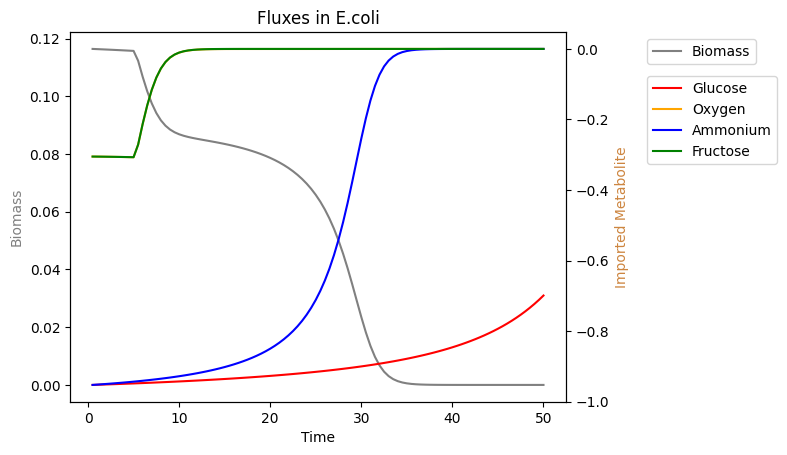

In [59]:
glucose = []
oxygen = []
ammonium = []
fructose = []
biomass = []

for i in fluxes_E:
    glucose.append(i["EX_glc__D_e"])
    biomass.append(i["BIOMASS_Ec_iML1515_core_75p37M"])
    oxygen.append(i["EX_o2_e"])
    fructose.append(i["EX_no_e"])
    ammonium.append(i["EX_nh4_e"])

ax = plt.subplot(111)
ax.plot(time_point[1:], biomass, color="gray", label="Biomass")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], glucose, color="red", label="Glucose")
ax2.plot(time_point[1:], oxygen, color="orange", label="Oxygen")
ax2.plot(time_point[1:], ammonium, color="blue", label="Ammonium")
ax2.plot(time_point[1:], fructose, color="green", label="Fructose")
ax.set_ylabel("Biomass", color="gray")
ax2.set_ylabel("Imported Metabolite", color="peru")
ax.set_xlabel('Time')

ax.set_title("Fluxes in E.coli")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

In [45]:
exchanges = []
for i in M_xanthus.exchanges:
    exchanges.append(i.id)

imported = []
for j in exchanges:
    if fluxes_M[0][j] < 0:
        print(j + ": " + str(fluxes_M[0][j]))
        imported.append(j)
len(imported)

EX_his_L_e: -0.44914174859266326
EX_met_L_e: -0.8811848730957959
EX_mg2_e: -0.009393712939926505
EX_cgly_e: -0.009393712939926507
EX_fum_e: -100.0
EX_so4_e: -0.009393712939926508
EX_pydx_e: -0.009393712939926503
EX_spmd_e: -0.009393712939926507
EX_glyc3p_e: -98.96838777168026
EX_orn_e: -1.40728432372833
EX_acald_e: -100.0
EX_leu_L_e: -2.127115135188855
EX_lys_L_e: -1.617414948583695
EX_k_e: -0.009393712939926505
EX_cu2_e: -0.009393712939926507
EX_fe3_e: -0.028181138819779523
EX_gam_e: -15.389368706560347
EX_gly_cys_L_e: -6.499822934240638
EX_h_e: -6.883810876762834
EX_ca2_e: -0.009393712939926503
EX_zn2_e: -0.009393712939926507
EX_cl_e: -0.009393712939926505
EX_pheme_e: -0.009393712939926507
EX_glu_L_e: -100.0
EX_mn2_e: -0.009393712939926503
EX_succ_e: -3.4821802618225868
EX_nh4_e: -0.9519450800915332
EX_ile_L_e: -1.3701346600326791
EX_cobalt2_e: -0.009393712939926505
EX_acac_e: -19.136811250361202
EX_val_L_e: -2.0146926120416717
EX_no_e: -100.0
EX_o2_e: -0.9519450800915332


33

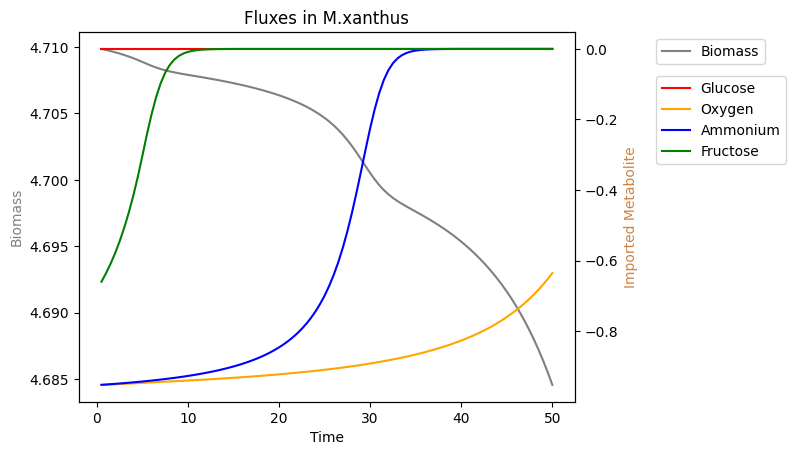

In [60]:
glucose = []
oxygen = []
ammonium = []
fructose = []
biomass = []

for i in fluxes_M:
    glucose.append(i["EX_glc__D_e"])
    biomass.append(i["OF_BIOMASS"])
    oxygen.append(i["EX_o2_e"])
    ammonium.append(i["EX_nh4_e"])
    fructose.append(i['EX_no_e'])

ax = plt.subplot(111)
ax.plot(time_point[1:], biomass, color="gray", label="Biomass")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], glucose, color="red", label="Glucose")
ax2.plot(time_point[1:], oxygen, color="orange", label="Oxygen")
ax2.plot(time_point[1:], ammonium, color="blue", label="Ammonium")
ax2.plot(time_point[1:], fructose, color="green", label="Fructose")

ax.set_ylabel("Biomass", color="gray")
ax2.set_ylabel("Imported Metabolite", color="peru")
ax.set_xlabel('Time')

ax.set_title("Fluxes in M.xanthus")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

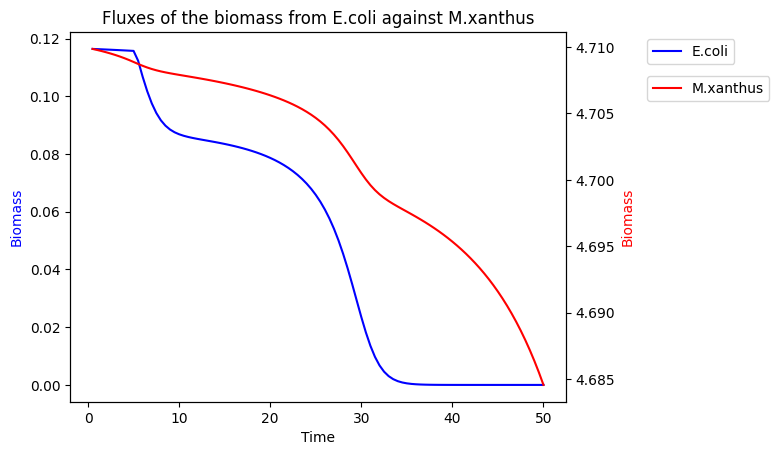

In [61]:
biomass_E = []
biomass_M = []

for i in fluxes_M:
    biomass_M.append(i["OF_BIOMASS"])
for j in fluxes_E:
    biomass_E.append(j['BIOMASS_Ec_iML1515_core_75p37M'])


ax = plt.subplot(111)
ax.plot(time_point[1:], biomass_E, color="b", label="E.coli")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], biomass_M, color="r", label="M.xanthus")

ax.set_ylabel("Biomass", color="b")
ax2.set_ylabel("Biomass", color="r")
ax.set_xlabel('Time')

ax.set_title("Fluxes of the biomass from E.coli against M.xanthus")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")